# Customer Transaction Prediction

Based on the data in https://www.kaggle.com/c/santander-customer-transaction-prediction/data

In [33]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMClassifier
import scipy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix, vstack, hstack
from scipy.linalg import hadamard
from scipy.sparse import issparse
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.model_selection import KFold


## Data Processing


In [3]:
train_df = pd.read_csv('./train.csv').loc[:2000, :]
test_df = pd.read_csv('./test.csv').loc[:2000, :]

In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [132]:
x_vals = train_df.iloc[:, 2:].values
y_vals = train_df['target'].values

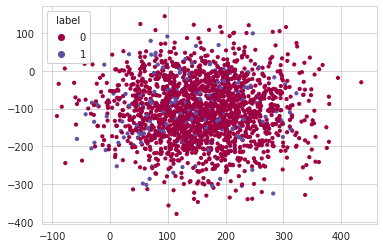

In [159]:
class HadamardReducer(TransformerMixin, BaseEstimator):
    
    '''
    Hadamard" is a linear dimensionality-reduction that
    projects input data on a lower-dimensional space using a slice of a HadamardMatrix. 
    This method attempts to approximate a random projection.
    It is computationally efficient for datasets that have a large number of features;
    The method nearly preserves the pairwise distances of high-dimensional data, 
    similarly to a random projection. 

    Implementation of direct evaluation of 
    Hadamard dimension reduction method using projection of
    input date on to a slice of 
    Hadamard matrix
    '''

    def __init__(self, n_components = 2, normalize = 'False'):
        self.normalize = normalize
        self.n_components = n_components

    def fit(self, X, y=None):
        return self

    def _pre_process(self, X):
        X = X.toarray() if scipy.sparse.issparse(X) else X
        scaler = StandardScaler()
        return scaler.fit_transform(X) if self.normalize else X 
     
    def transform(self, X):
        self._m, self._n = X.shape
        if self.normalize == 'True':
            X = self._pre_process(X) 
        hdim = int(2**(round(np.log2(self._n)+1)))
        padd = csr_matrix((self._m, hdim-self._n), dtype='float64') 
        #if scipy.sparse.issparse(X) else np.zeros((self._m, hdim-self._n), dtype='float64') 
        Xh = hstack([X, padd]) if hdim > self._n else X 
        yp = Xh.dot(hadamard(hdim))
        return yp[:, 2:self.n_components + 2]

#visulazing the data in 2d projection is not informative
had = HadamardReducer(normalize = True)
X_embedded = had.fit_transform(x_vals)
fig, ax = plt.subplots()
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y_val, s=10, cmap='Spectral')
legend = ax.legend(*scatter.legend_elements(),
                loc="upper left", title="label")
ax.add_artist(legend)


# Data Distribution and EAD

Plots of data distribution

In [106]:
features = train_df.columns.values[2:]

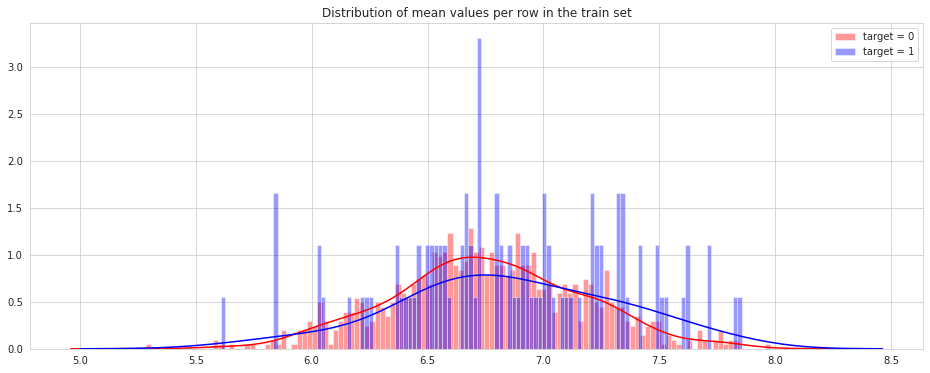

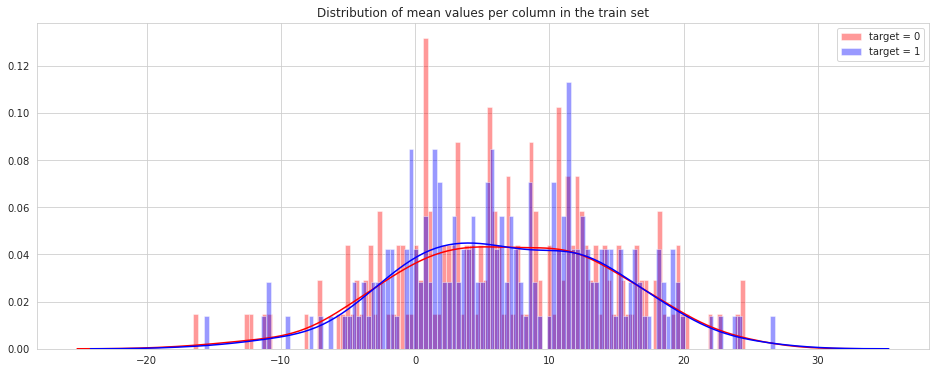

In [112]:
import seaborn as sns
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]

plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()



# checking the missing data and type of the features

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

## Corrlation matrix

<Figure size 432x288 with 0 Axes>

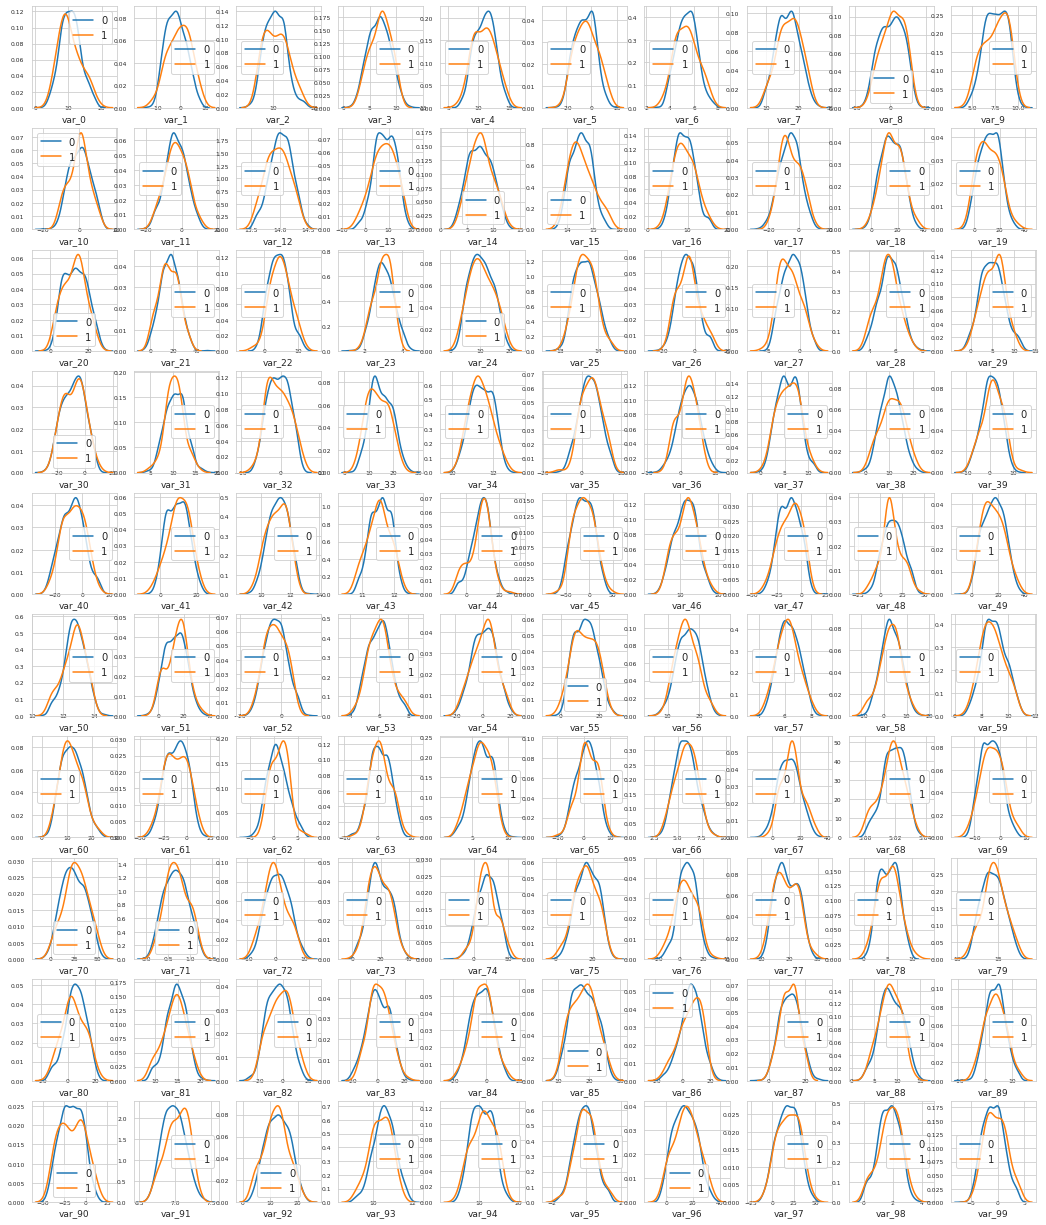

In [111]:
#Plots of data distribution

def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

t0 = train_df[train_df['target'] == 0]
t1 = train_df[train_df['target'] == 1]

plot_feature_distribution(t0, t1, '0', '1', features[:100])

In [115]:
# corrlation matrix

corr_matrix = train_df[features].corr(method = 'pearson')

In [116]:
corr_matrix

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,0.017778,0.033657,0.027129,0.006487,0.022108,-0.041090,0.042190,0.049944,-0.029650,...,0.012101,0.008638,-0.001370,-0.029500,-0.052892,-0.060394,-0.021651,-0.006938,0.023501,0.013303
var_1,0.017778,1.000000,0.054850,0.016908,0.047731,0.005922,0.005951,0.067874,0.004449,-0.060585,...,0.006374,-0.029074,-0.014830,0.020089,-0.034557,0.030063,-0.039524,-0.018804,-0.012494,0.059223
var_2,0.033657,0.054850,1.000000,-0.014556,0.009192,-0.001258,-0.015708,-0.006659,0.042429,0.007059,...,-0.059758,0.060808,0.001639,0.020843,0.000333,-0.005915,-0.025989,0.000147,0.033775,0.034191
var_3,0.027129,0.016908,-0.014556,1.000000,0.046901,-0.030931,-0.017469,0.012554,0.003494,-0.040364,...,0.014519,-0.029292,-0.016867,-0.016029,-0.036007,0.027054,0.003327,0.006591,-0.015445,0.033504
var_4,0.006487,0.047731,0.009192,0.046901,1.000000,-0.001713,-0.002260,0.036892,0.063236,0.027510,...,0.005744,0.008722,0.005043,0.016023,0.038551,0.039234,-0.020967,0.045769,0.030736,-0.024078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,-0.060394,0.030063,-0.005915,0.027054,0.039234,0.035132,-0.040768,-0.027521,0.066680,0.010019,...,-0.013170,-0.042264,-0.007107,0.025145,-0.007968,1.000000,0.004512,-0.025438,-0.061400,-0.022863
var_196,-0.021651,-0.039524,-0.025989,0.003327,-0.020967,0.035670,0.066482,-0.034174,0.021337,-0.014855,...,0.016297,0.018561,-0.011846,-0.042353,-0.016328,0.004512,1.000000,-0.051621,0.027419,-0.036077
var_197,-0.006938,-0.018804,0.000147,0.006591,0.045769,-0.012621,0.038618,-0.059141,0.051752,-0.022227,...,-0.047175,-0.024881,0.010693,0.016002,0.010252,-0.025438,-0.051621,1.000000,-0.050686,-0.026386
var_198,0.023501,-0.012494,0.033775,-0.015445,0.030736,0.024075,-0.005222,0.000097,-0.096585,0.045545,...,-0.049198,0.090546,-0.010696,-0.000639,0.032568,-0.061400,0.027419,-0.050686,1.000000,-0.011484


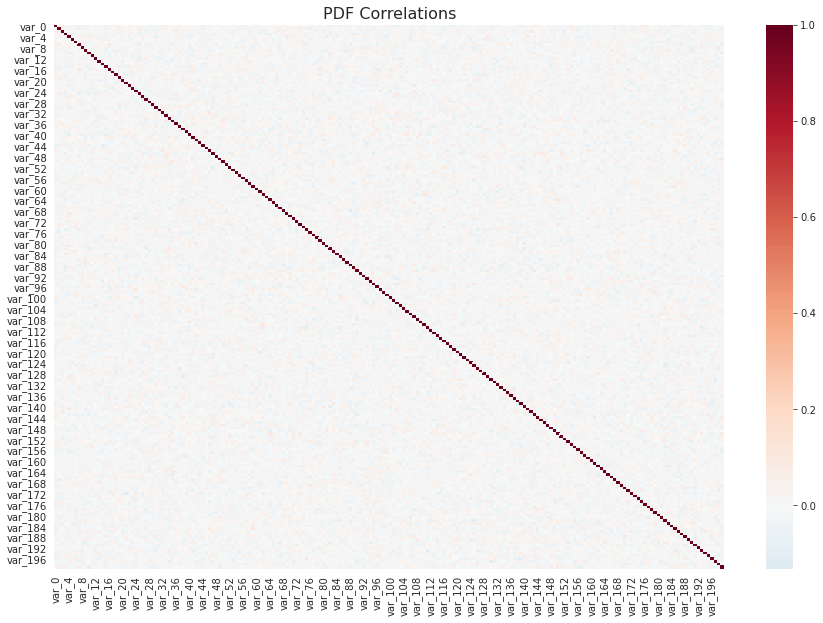

In [120]:
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, cmap = 'RdBu_r', center=0.0) 
plt.title('PDF Correlations',fontsize=16)
plt.show() 

In [124]:
pair_corr = corr_matrix.abs().unstack().sort_values(kind="quicksort").reset_index()
pair_corr_mod = pair_corr[pair_corr['level_0'] != pair_corr['level_1']]

In [164]:
#least corrlated features
pair_corr_mod[:10] 

,level_0,level_1,0
0,var_181,var_164,5.238619e-07
1,var_164,var_181,5.238619e-07
2,var_177,var_133,4.704558e-06
3,var_133,var_177,4.704558e-06
4,var_165,var_46,5.556617e-06
5,var_46,var_165,5.556617e-06
6,var_33,var_59,7.410102e-06
7,var_59,var_33,7.410102e-06
8,var_132,var_162,1.409274e-05
9,var_162,var_132,1.409274e-05


In [126]:
## top Most corrlated features
pair_corr_mod[-10:]  

,level_0,level_1,0
39790,var_21,var_172,0.114841
39791,var_172,var_21,0.114841
39792,var_109,var_40,0.116178
39793,var_40,var_109,0.116178
39794,var_110,var_62,0.116485
39795,var_62,var_110,0.116485
39796,var_32,var_46,0.116504
39797,var_46,var_32,0.116504
39798,var_88,var_68,0.131395
39799,var_68,var_88,0.131395


In [170]:
# Adding some aggregation of existing features as new featuresabs
    
for df in [train_df, test_df]:
    df['sum_fe'] = df[features].sum(axis = 1)
    df['mean_fe'] = df[features].mean(axis = 1)

In [ ]:
target = train_df['target']

In [5]:

def build_train_test(train_path = './train.csv', test_path = './test.csv', max_rows = 1000):
    #use small max row to test
    
    train_df = pd.read_csv(train_path).loc[:max_rows, :]
    test_df = pd.read_csv(test_path).loc[:max_rows, :]
    features = train_df.columns.values[2:]
    for df in [train_df, test_df]:
        df['sum'] = df[features].sum(axis = 1)
        df['mean'] = df[features].mean(axis = 1)
        df['median'] = df[features].median(axis = 1)
    target = train_df['target']
    features = train_df.columns.values[2:]
    return train_df, test_df, target, features
    


In [6]:
train, test, y, features = build_train_test()

In [7]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_193,var_194,var_195,var_196,var_197,var_198,var_199,sum,mean,median
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914,1456.3182,7.281591,6.77040
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518,1415.3636,7.076818,7.22315
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965,1240.8966,6.204483,5.89940
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996,1288.2319,6.441159,6.70260
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104,1354.2310,6.771155,6.94735


## Train a Gradient Boosted Tree model

Using lightGBM lib. we train a classifer on the kfold cross validated set and report model for average out of fold metrics including AUC and precision-recall curves. Here the feature importance of top 50 features is visualized.

In [31]:
def train_model(data_, test_, y_, folds_, feats_):

    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats_].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats_].iloc[val_idx], y_.iloc[val_idx]
        
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.03,
            num_leaves=30,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=7,
            reg_alpha=.1,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
               )
        
        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats_], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats_
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['TARGET'] = sub_preds

    return oof_preds, test, feature_importance_df
    

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')


def display_roc_curve(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = roc_auc_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    fpr, tpr, thresholds = roc_curve(y_, oof_preds_)
    score = roc_auc_score(y_, oof_preds_)
    plt.plot(fpr, tpr, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LightGBM ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig('roc_curve.png')


def display_precision_recall(y_, oof_preds_, folds_idx_):
    # Plot ROC curves
    plt.figure(figsize=(6,6))
    
    scores = [] 
    for n_fold, (_, val_idx) in enumerate(folds_idx_):  
        # Plot the roc curve
        fpr, tpr, thresholds = roc_curve(y_.iloc[val_idx], oof_preds_[val_idx])
        score = average_precision_score(y_.iloc[val_idx], oof_preds_[val_idx])
        scores.append(score)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AP fold %d (AUC = %0.4f)' % (n_fold + 1, score))
    
    precision, recall, thresholds = precision_recall_curve(y_, oof_preds_)
    score = average_precision_score(y_, oof_preds_)
    plt.plot(precision, recall, color='b',
             label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('LightGBM Recall / Precision')
    plt.legend(loc="best")
    plt.tight_layout()
    
    plt.savefig('recall_precision_curve.png')

## Results:

Feature importance, AUC, precision-recall for out of folds estimates and their averages.   

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	training's binary_logloss: 0.061776	valid_1's auc: 0.52532	valid_1's binary_logloss: 0.348375
Early stopping, best iteration is:
[2]	training's auc: 0.934922	training's binary_logloss: 0.305081	valid_1's auc: 0.590909	valid_1's binary_logloss: 0.321363
Fold  1 AUC : 0.590909
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	training's binary_logloss: 0.0642884	valid_1's auc: 0.566874	valid_1's binary_logloss: 0.311939
Early stopping, best iteration is:
[32]	training's auc: 1	training's binary_logloss: 0.172203	valid_1's auc: 0.578067	valid_1's binary_logloss: 0.294405
Fold  2 AUC : 0.578067
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 1	training's binary_logloss: 0.0597476	valid_1's auc: 0.615628	valid_1's binary_logloss: 0.354557
Early stopping, best iteration is:
[30]	training's auc: 1	training's binary_logloss: 0.173594	vali

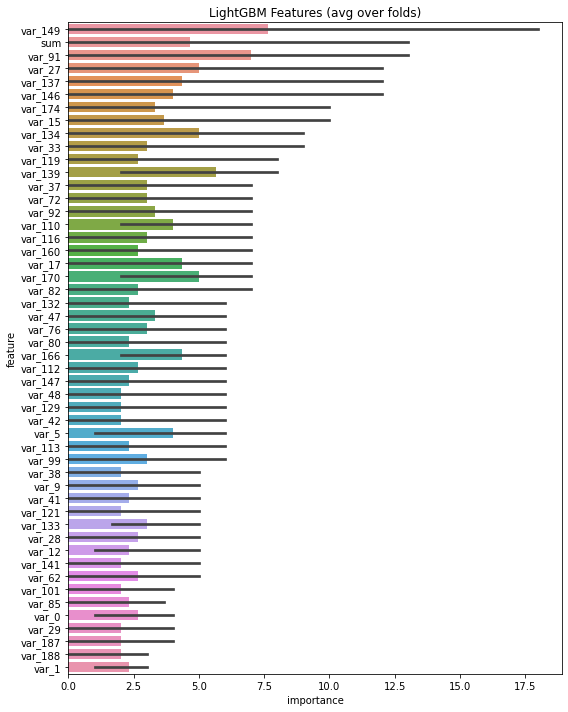

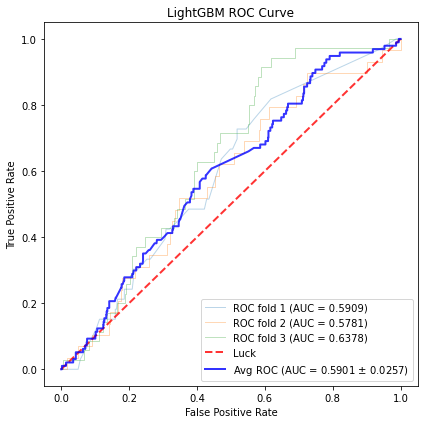

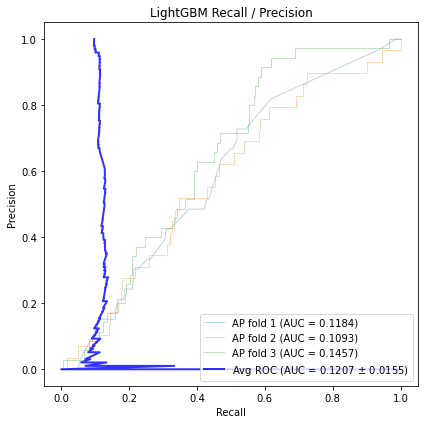

In [35]:
# Create Folds
folds = KFold(n_splits=3, shuffle=True, random_state=546789)
# Train model and get oof and test predictions
oof_preds, test_preds, importances = train_model(train, test, y, folds, features)

# Display a few graphs
data = train
folds_idx = [(trn_idx, val_idx) for trn_idx, val_idx in folds.split(data)]
display_importances(feature_importance_df_=importances)
display_roc_curve(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)
display_precision_recall(y_=y, oof_preds_=oof_preds, folds_idx_=folds_idx)